## 5 Trip Distribution
Version 0.1

This file contains the tutorial part of Omnitrans for trip distribution translated to python.

Input:
- Simple network with centroids
- Trip productions and attractions
- Impedances

Further changes depending on other parts of tutorial may be needed.

In [1]:
# Import packages needed
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
from ipfn import ipfn # Furness process

%matplotlib inline

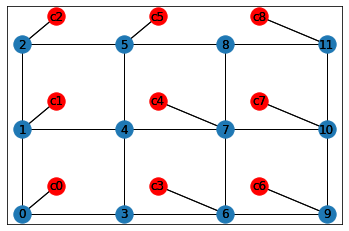

In [2]:
# Create simple network with centroids and add attributes
# Future steps, include more code flexibility

g = nx.grid_2d_graph(4,3)
g = nx.convert_node_labels_to_integers(g)
att = {i:{'coord':(i//3, i%3),'centroid':False} for i in g.nodes}
nx.set_node_attributes(g,att)
att_e = {i:{'type':'road','tt':10} for i in g.edges}
nx.set_edge_attributes(g,att_e)
for i in range(0,9):
    g.add_node(f'c{i}', coord=(1/3+i//3,1/3+i%3))
    g.nodes[f'c{i}']['centroid'] = True
    g.nodes[f'c{i}']['tt'] = 3
pos = nx.get_node_attributes(g, 'coord')
ls_e = [('c0',0),('c1',1),('c2',2),('c3',6),('c4',7),('c5',5),('c6',9),('c7',10),('c8',11)] #Hard coded
g.add_edges_from(ls_e, type='connector')
centroids = [e for e in g.nodes if g.nodes[e]['centroid']]
for e in ls_e:
    g.edges[e]['tt']=1

nx.draw_networkx(g, pos=pos, nodelist=[e for e,v in nx.get_node_attributes(g,'centroid').items() if not v])
nx.draw_networkx(g, pos=pos, nodelist=[e for e,v in nx.get_node_attributes(g,'centroid').items() if v], node_color='r')
plt.show()

In [3]:
# Fill random production/attraction dataframe
np.random.seed(0)
df = pd.DataFrame(np.random.randint(0,100, size=(9,2)), columns=list('PA'))
df.A = df.A*sum(df.P)/sum(df.A) # Balancing
df.A = df.A.astype(int) # Only integers
df.A[0] = df.A[0] + sum(df.P)-sum(df.A) # Add remainder to first centroid

In [4]:
def construct_skim(graph, number_of_centroids=9):
    skm = np.zeros((number_of_centroids,number_of_centroids))
    centroids = [e for e in graph.nodes if graph.nodes[e]['centroid']]
    for i, v in enumerate(centroids):
        skm[i][i]=9999 # No intrazonal traffic
        for j, w in enumerate(centroids):
            if not v == w:
                p = nx.shortest_path(graph, source=v, target=w, weight='tt') # Travel time shortest path (static)
                q = [(i, j) for i, j in zip(p, p[1:])]
                q[0]=(q[0][1],q[0][0]) # connector to centroid is in reverse order (hard coded)
                cost = sum([graph.edges[e]['tt'] for e in q])
                skm[i][j]=cost
    return skm

In [5]:
# Distribution function

# - exponential
def dist_exponential(a, b, m):
    return a*np.exp(-b*m)

# - lognormal
## add later

In [6]:
# Reproduce example from lecture notes Traffic Engineering (p78-)
#PA
#df = pd.DataFrame({'P':[400,460,400,702], 'A':[260,400,500,802]})
#skm = np.array([[3,11,18,22],[12,3,13,19],[15.5,13,5,7],[24,18,8,5]])

In [7]:
def trip_distribution(df_pa, skim, *args, function='exponential'):
    if function == "exponential":
        skm2 = dist_exponential(*args, skim) # Distribution function, choose parameters
    prod = df_pa.P
    attr = df_pa.A
    aggregates = [prod, attr]
    dimensions = [[0],[1]]
    IPF = ipfn.ipfn(skm2, aggregates, dimensions) # Furness iteration process
    trips = IPF.iteration()
    od = pd.DataFrame(trips)
    return od

In [8]:
skm = construct_skim(g)
od = trip_distribution(df, skm, 1, 0.1)

In [9]:
# Desire lines (just to show how trips are distributed)
# Not a lot of added value theoretically
def draw_desire_lines(od, graph, centroid, cmap=plt.cm.viridis):
    centroids = [e for e in graph.nodes if graph.nodes[e]['centroid']]
    od.index = centroids
    od.columns = centroids
    pos = nx.get_node_attributes(graph, 'coord')
    d_lines = nx.DiGraph()
    d_lines.add_nodes_from(graph)
    d_lines.remove_nodes_from([i for i in graph.nodes if not graph.nodes[i]['centroid']]) # Only keep centroid nodes
    d_lines.add_edges_from([(centroid,i) for i in centroids])
    nx.draw_networkx(graph, pos=pos, nodelist=[e for e,v in nx.get_node_attributes(graph,'centroid').items() if not v])
    nx.draw_networkx(graph, pos=pos, nodelist=[e for e,v in nx.get_node_attributes(graph,'centroid').items() if v], node_color='r')
    nx.draw_networkx_edges(d_lines, pos=pos, width=od.loc[centroid].values/max(od.loc[centroid])*10, edge_color=od.loc[centroid].values, edge_cmap=cmap)
    plt.show()


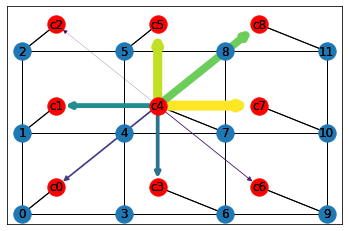

In [10]:
draw_desire_lines(od, g, 'c4')

In [11]:
skm

array([[9999.,   12.,   22.,   22.,   32.,   32.,   32.,   42.,   52.],
       [  12., 9999.,   12.,   32.,   22.,   22.,   42.,   32.,   42.],
       [  22.,   12., 9999.,   42.,   32.,   12.,   52.,   42.,   32.],
       [  22.,   32.,   42., 9999.,   12.,   32.,   12.,   22.,   32.],
       [  32.,   22.,   32.,   12., 9999.,   22.,   22.,   12.,   22.],
       [  32.,   22.,   12.,   32.,   22., 9999.,   42.,   32.,   22.],
       [  32.,   42.,   52.,   12.,   22.,   42., 9999.,   12.,   22.],
       [  42.,   32.,   42.,   22.,   12.,   32.,   12., 9999.,   12.],
       [  52.,   42.,   32.,   32.,   22.,   22.,   22.,   12., 9999.]])

In [12]:
od

,c0,c1,c2,c3,c4,c5,c6,c7,c8
c0,0.000000,27.281226,1.150712,2.829468,3.373878,6.887149,0.656878,1.026508,0.794454
c1,26.108201,0.000000,3.181629,1.058762,9.328506,19.042424,0.245798,2.838214,2.196604
c2,6.432374,18.584075,0.000000,0.260851,2.298299,34.666143,0.060558,0.699261,3.998849
c3,12.358637,4.832271,0.203823,0.000000,32.628320,9.013965,6.352577,9.927221,7.683062
c4,1.588884,4.590520,0.193626,3.517966,0.000000,8.563010,0.816717,9.430577,7.298690
c5,5.304714,15.326100,4.776651,1.589544,14.005098,0.000000,0.369022,4.261074,24.367710
c6,5.022799,1.963932,0.082838,11.121037,13.260806,3.663457,0.000000,29.812053,23.072705
c7,0.842250,2.433384,0.102639,1.864835,16.430624,4.539157,3.198963,0.000000,28.587925
c8,0.342140,0.988492,0.308081,0.757536,6.674469,13.624696,1.299487,15.005092,0.000000
